# Introduction

Topological Data Analysis (TDA) is a method to simplify highly complex and many-dimensional data.
It does this by clustering datapoints and considering the connections between them. This was
first used by Singh, Mémoli and Carlson in 2007 with the `Mapper` algorithm.<cite data-cite="Singh2007">(Singh, 2008)</cite>
In this work, I use the `KeplerMapper` implementation in `Python`.<cite data-cite="KeplerMapper">(KeplerMapper)</cite>
TDA is useful as a technique because it is generally applicable for any dataset in which there there is a metric of similarity or closeness, not just in Euclidean space (where the metric is $\left|\vec{r}_1 - \vec{r}_2\right|$). It is especially good when the dataset is very high dimensional and sparse in that space. TDA can simplify the dataset into a human-readable form while preserving the significant features of the original dataset. It is built on the mathematical underpinnings of topology, in that it preserves local nearness (because the data points within a cluster are near to one another, and linked clusters are also near to one another in the data space) but does not preserve long distances. This is useful in chemical analysis, because chemical space using fingerprints often has thousands of dimensions. While the similarity of two compounds is important and implies that they should have similar chemical properties, if two compounds are greatly dissimilar we cannot say anything about their respective properties.

## Related Works
Topological Data Analysis has been used to analyse gene expression in asthma sufferers,<cite data-cite="Schofield2019">(Schofield, 2019)</cite>, analysis of zeolite storage<cite data-cite="Lee2017">(Lee, 2017)</cite>, progression of breast cancer <cite data-cite="Nicolau2011">(Nicolau, 2011)</cite> and interpretability of machine learning programs, amongst others. One interesting use of the TDA technique that I focus on in **Chapter 4** is the Fibres of Failure method, which uses TDA on machine learning prediction errors in an attempt to correct for them. <cite data-cite="Carlsson2018">(Carlsson, 2018)</cite>

For the machine learning section, I use a Random Forest predictor as developed by Svetnik in 2003. <cite data-cite="Svetnik2003">(Svetnik, 2003)</cite> Random Forests have been used in chemistry by Banerjee and Preissner to predict whether a given compound will be sweet or bitter achieving accuracy of over 95%<cite data-cite="Banerjee2018">(Banerjee, 2018)</cite>, and by Palmer et al to predict solubility of compounds<cite data-cite="Palmer2006">(Palmer, 2006)</cite>, amongst others. Random Forest is a supervised machine learning method that builds a series of decision trees, and it is often used by data scientists because the individual decisions are interpretable. A Random Forest essentially places weights on each feature of an observation, and decides based on the importance of each feature. Each decision node is only given a subset of the data in a technique called \enquote{bootstrapping}, so it can also estimate its own inaccuracy.

# Theory and Computational Method
## Theory

Topological Data Analysis (TDA) works by constructing a simple lens (sometimes referred to as a filter function) which reduces the dimensionality of the data. For example, for a series of points in the $xyz$ plane, projection on the $y$ axis may be a suitable lens. Lens are not restricted to being a simple function of the data, however, and can be more abstract -- in this work, I use the results of dimensionality reduction algorithms or properties of chemicals as the lens. 

Then, a cover is constructed in the lens space. This is a series of overlapping hypercubes, so in our $xyz$ plane example we may use boxes from $0 \to 0.4$, $0.3 \to 0.7$ and $0.6 \to 1.0$ along $y$. The algorithm then looks at the data points contained within each box, and applies a clustering algorithm on the original data. This means that the data loss from the dimensionality reduction is prevented. 

The clusters are placed on the graph, and if any two clusters share a data point in the original data, the algorithm draws an edge between them. It proceeds like this until all the data is processed. Mathematically, this is constructing the \enquote{nerve} of the cover. The progress is demonstrated in Figure 1, taken from Chazal *et al*.<cite data-cite="Chazal2017">(Chazal, 2017)</cite>.

Finally, we can colour the graph and visualise it to aid human interpretation.

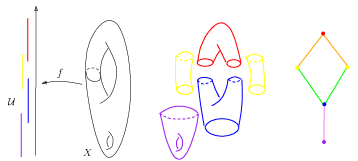

In [1]:
from wand.image import Image as WImage
img = WImage(filename='croppedfig.pdf')
img

## Computational Method
All of the computational work in this report was done using `Python 3.7` and the Jupyter notebook.
This was chosen because of the range of available software packages, and its ease of use.

In [2]:
import pickle
import sys
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
%config InlineBackend.figure_format = 'pdf'
import IPython
from IPython.display import SVG, IFrame

In [3]:
DESIRED_TARGETS = ["CHEMBL240"]
DRUG_SPACE_TARGETS = ["CHEMBL4015", "CHEMBL2409"]
# To ensure repeatability of runs, the random seed should
# be consistent.
RANDOM_STATE = 2019
RENEW_MATRIX = False
# Data splitting hyperparameters.
TRAIN_RF_FRACTION = 0.60
TRAIN_FIFA_FRACTION = 0.20
VALIDATE_FRACTION = 1.0 - TRAIN_FIFA_FRACTION - TRAIN_RF_FRACTION

# Community detection hyperparameters.
# Discard any with too small a set of nodes,
# or too small a prediction error.
COMMUNITY_SIZE_CUTOFF = 3
COMMUNITY_ERROR_CUTOFF = 0.10
COMMUNITY_STD_CUTOFF = 0.10

The dataset used in this work was taken from a sanitised version of the ChEMBL database created by Lenselink *et al*. <cite data-cite="Gaulton2012">(Gaulton, 2012)</cite><cite data-cite="Lenselink2017">(Lenselink, 2017)</cite> This dataset contains only the entries in ChEMBL that have minimal experimental error, confident numerical ratings and no duplicate measurements. From this dataset, I used RDKit to parse chemical information into a computationally-accessible format.<cite data-cite="rdkit">(RDKit)</cite> The drugs were converted into SMILES strings, and their chemical fingerprints were calculted using a Morgan Fingerprinting algorithm with
a fingerprint radius of 3 bonds and a fingerprint size of 2048 bits.

In [4]:
ACTIVITY_CUTOFF = 5.4

In the dataset, activity is quantified by a `pChEMBL` value, which is logarithmic and ranges between 1 and 10. Examples in the literature often demarcate "active" vs "inactive" at `pChEMBL = 5.0`, but this classifies 90% of 
compounds in the dataset as active. Instead, `pChEMBL = 5.4` is used as a cutoff because this makes half the dataset active and half inactive.

In [5]:
FP_SIZE = 2048

In [6]:
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import DataStructs

In [7]:
input_location = "../data/processed/curated_set_with_publication_year.pd.pkl"
with open(input_location, "rb") as infile:
    df = pickle.load(infile)

possible_targets = Counter([item for item in df["TGT_CHEMBL_ID"]])
possible_drugs = Counter([item for item in df["CMP_CHEMBL_ID"]])

In [8]:
fingerprint_dict = {}
for index, row in df.iterrows():
    target = row["TGT_CHEMBL_ID"]
    if target in DESIRED_TARGETS:
        drug = row["CMP_CHEMBL_ID"]
        molec = Chem.MolFromSmiles(row["SMILES"])
        fingerprint_dict[drug] = AllChem.GetMorganFingerprintAsBitVect(molec,
                                                                       radius=3,
                                                                       nBits=FP_SIZE)

I used KeplerMapper to perform the topological data analysis.<cite data-cite="KeplerMapper">(KeplerMapper)</cite>  This is a free and open source
implementation of the Mapper algorithm which runs in `Python`. To do further graph manipulations including community detection, I used the `igraph` package.<cite data-cite="igraph">(igraph)</cite>

In [9]:
import kmapper as km
import igraph

In [10]:
def keplermapper_to_igraph(old_graph):
    """
    Converts a KeplerMapper graph into an igraph
    format for plotting and community detection
    """
    new_graph = igraph.Graph()
    vertices = list(old_graph["nodes"].keys())
    new_graph.add_vertices(vertices)

    edges = []
    for link in old_graph["links"]:
        edges.extend([(link, otherlink) for otherlink in old_graph["links"][link]])
    new_graph.add_edges(edges)
    return new_graph

In [11]:
def _repr_svg_patch_(self):
    """
    Returns an SVG representation of this plot as a string.
    This method is used by IPython to display this plot inline.
    Patched by Matt Bailey 2019-04-30 to fix a Python 3 compatibility
    issue.
    """
    io = igraph.compat.BytesIO()
    cairo = igraph.drawing.utils.find_cairo()
    surface = cairo.SVGSurface(io, self.bbox.width, self.bbox.height)
    context = cairo.Context(surface)
    self.redraw(context)
    context.show_page()
    surface.finish()
    result = io.getvalue()
    if hasattr(result, "encode"):
        return result.encode("utf-8")          # for Python 2.x
    else:
        return result.decode("utf-8")          # for Python 3.x


setattr(igraph.drawing.Plot, "_repr_svg_", _repr_svg_patch_)

Topological data analysis requires an algorithm to cluster the datapoints into nodes. I used the `HDBSCAN` algorithm
to perform this task, because it is designed to cope well with varying densities of data points. This is important for analysis of chemical space, because the density of experimental data is often inconsistent.<cite data-cite="McInnes2017">(McInnes, 2017)</cite>

In [12]:
import hdbscan
clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=5, min_samples=2)
fifa_clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=3, min_samples=1)

Finally, I used Scikit-Learn to do to the machine learning in this work.<cite data-cite="scikit-learn">(Scikit-Learn)</cite>

In [13]:
import sklearn.ensemble
from sklearn.manifold import MDS

# Qualitative Results
## Exploring Chemical Space
One powerful way to use topological data analysis is to explore the similarities in chemical space in a human-readable form. To do so, we must quantify the "distance" between two compounds in chemical space. I have
chosen to do so with the Tanimoto Similarity, which is
\begin{equation}
   d_T = \frac{M_{11}}{M_{10} + M_{01} - M_{11}}
\end{equation}
with $M_{11}$ being the number of shared 1s in two fingerprints and $M_{10} + M_{01}$ being the number of 1s in one fingerprint but not in the other.

Generating the distance matrix for a set of compounds is an $\mathcal{O}\left(N^2\right)$ operation in both time and memory. The
distance matrix calculation was the limiting factor for the amount of data I could analyse.

In [14]:
chem_space_df = df[np.logical_or.reduce([df["TGT_CHEMBL_ID"] == tgt
                                         for tgt in DESIRED_TARGETS])]
chem_space_df = sklearn.utils.shuffle(chem_space_df,
                                      random_state=RANDOM_STATE)

In [15]:
if RENEW_MATRIX:
    distance_matrix = np.zeros([len(chem_space_df), len(chem_space_df)])
    for index in range(len(chem_space_df)):
        drug = chem_space_df.iloc[index]["CMP_CHEMBL_ID"]
        fp_1 = fingerprint_dict[drug]
        for other_index in range(index):
            other_drug = chem_space_df.iloc[other_index]["CMP_CHEMBL_ID"]
            fp_2 = fingerprint_dict[other_drug]
            distance = 1.0 - rdkit.DataStructs.TanimotoSimilarity(fp_1, fp_2)
            distance_matrix[index, other_index] = distance
            distance_matrix[other_index, index] = distance
    pickle.dump(distance_matrix, open("chemical-space-distance.pkl", "wb"))
else:
    with open("chemical-space-distance.pkl", "rb") as pklfile:
        distance_matrix = pickle.load(pklfile)

In [16]:
%matplotlib inline

plt.imshow(distance_matrix, cmap='magma')
plt.colorbar()
plt.savefig("./Figures/distance-matrix.pdf")

<Figure size 432x288 with 2 Axes>

In the visualisation of the distance matrix above, we can see that almost all compounds are very distinct from the others in the dataset, with only small points of similar compounds. This is likely because synthetic chemists like to publish data about compounds that are different to those that have come before.

The key feature of topological data analysis that makes it useful to explore chemical space is that it shows low-dimensional data while keeping the links of high-dimensional data. Here, I use Multi-Dimensional Scaling (MDS) to reduce the dimensionality of the data to two principal components. MDS works very similarly to principal component analysis, but is applicable to more general spaces (such as non-metric chemical space).<cite data-cite="Martin2015">(Martin, 2015)</cite>

In [17]:
mds_coordinate = MDS(n_components=1,
                     dissimilarity="precomputed",
                     metric=False).fit_transform(distance_matrix)

One of the weaknesses of the TDA technique is the degree of parameterisation. The clusterer and the cover used to construct the graph are both heavily parameterised, and these parameters can be tweaked cause great variation in the graphs produced.

In [18]:
cover = km.Cover(n_cubes=[5, 20], perc_overlap=[0.40, 0.15])
lens = np.concatenate([mds_coordinate, activities.reshape(-1, 1)], axis=1)

NameError: name 'activities' is not defined

In [ ]:
mapper = km.KeplerMapper(verbose=0)
graph = mapper.map(lens,
                   X=distance_matrix,
                   precomputed=True,
                   cover=cover,
                   clusterer=clusterer)

chemical_space_graph = keplermapper_to_igraph(graph)

When the TDA graphs are going to be analysed by humans, colouring the clusters by a property is important. This enables complex chemical information, such as "all of these similar chemicals are equally active" to be intuitively visualised. Here, I colour the clusters by the maximum bioactivity of the compounds within the cluster to see which clusters are promising for drug discovery.

The colouring function can be an abstract property of the dataset which was not taken into account earlier. For instance, I could colour by solubility or by $pKa $ after using activity as a lens function, to see if there are any correlations between those properties and bioactivity.

In [ ]:
def normalise_array(arr):
    """
    Normalises an array or list to have
    all elements in the range [0-1)
    """
    arr = np.array(arr)
    color_func = arr - np.min(arr)
    arr = arr / np.max(arr)
    return arr

In [ ]:
cmap = plt.cm.get_cmap("viridis")
color_activities = []
color_otherprops = []
for vertex in chemical_space_graph.vs:
    chem_indices = graph["nodes"][vertex["name"]]
    vertex_activities = np.array([chem_space_df.iloc[index]["BIOACT_PCHEMBL_VALUE"]
                                  for index in chem_indices])
    vertex_otherprop = np.array([chem_space_df.iloc[index]["CMP_ACD_LOGD"]
                                  for index in chem_indices])
    color_otherprop = np.nanmax(vertex_otherprop)
    color_otherprops.append(color_otherprop)
    color_activity = np.nanmax(vertex_activities)
    color_activities.append(color_activity)

color_activities = normalise_array(color_activities)
color_otherprops = normalise_array(color_otherprops)

colors = []
for color_activity in color_activities:
    colors.append(cmap(color_activity))

colors_otherprop = []
for color_otherprop in color_otherprops:
    colors_otherprop.append(cmap(color_otherprop))


In [ ]:
layout = chemical_space_graph.layout("fr")
igraph.plot(chemical_space_graph, layout = layout,
            vertex_color = colors, edge_width=1.0,
            vertex_size=5, target="./Figures/chemical-space-graph.svg",
            inline=True)

In [ ]:
igraph.plot(chemical_space_graph, layout = layout,
            vertex_color = colors_otherprop, edge_width=1.0,
            vertex_size=5, target="./Figures/chemical-space-graph-otherprop.svg",
            inline=True)

The graphs produced by the TDA technique require some careful interpretation. Physical proximity in the graph doesn't imply any similarity in the points. Instead, the links are significant. The features to look out for are flares coming off a main backbone, and holes in the dataset. The flares imply groups of related clusters with a distinguishing feature from the rest of the dataset -- this is often chemically important. The holes in the graph represent regions where there is no data in chemical space. If there is a hole in a chemically active region, it may be there that are \enquote{missing link} chemicals that have not been studied.

For instance, in the graph coloured by bioactivity we can see a flare off the main graph of more active compounds, while the body of the graph is less active. We can look at the compounds which feature in this group, to see if there is any shared chemical structure. When we look at the graph coloured by partition coefficient ``CMP_ACD_LOGD``, there is no correlation between the graph and colouring. 

In [ ]:
def draw_molecule(SMILES_string):
    """
    Draws an SVG image of a molecule
    given a SMILES string
    """
    molec = Chem.MolFromSmiles(SMILES_string)
    rdDepictor.Compute2DCoords(molec)
    drawer = rdMolDraw2D.MolDraw2DSVG(250, 250)
    drawer.DrawMolecule(molec)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg

In [ ]:
max_index = np.argmax(color_activities)
max_node  = chemical_space_graph.vs[max_index]["name"]

mols = []
chem_ids = []
print("The members of one active cluster are: ", end="")
for member in graph["nodes"][max_node]:
    chem_ids.append(chem_space_df.iloc[member]["CMP_CHEMBL_ID"])
    mols.append(Chem.MolFromSmiles(chem_space_df.iloc[member]["SMILES"]))
SVG(Chem.Draw.MolsToGridImage(mols, molsPerRow=3, legends=chem_ids, subImgSize=(250, 250), useSVG=True))


## Drug Testing Space

The neither the underlying space or the lens used in TDA have to have any physical meaning. This means that TDA is useful to gain an understanding of the structure of datasets which are very abstract. Here, I will use TDA to look at which drug-target interactions have been studied in the ChEMBL database in the hope that it will make links between groups or absences clear.

Here, instead of a boolean chemical fingerprint, I am going to give each drug a "testing fingerprint". These fingerprints will be $n_\text{targets}$ long, each each entry will be
\begin{equation}
    V_{ij} = \begin{cases} +1 \qquad\text{ if } \quad i \text{ is active against } j \\  -1 \qquad \text{if} \quad i \quad \text{ is inactive against } j \\ 0 \qquad \text{ if } \quad i \text{, } j \text{has not been tested.}\end{cases}
\end{equation}

In [ ]:
vector_df = pd.DataFrame(0, columns=possible_drugs.keys(),
                         index=possible_targets.keys(),
                         dtype=np.int8)
for index, row in df.iterrows():
    drug = row["CMP_CHEMBL_ID"]
    target = row["TGT_CHEMBL_ID"]
    if row["BIOACT_PCHEMBL_VALUE"] > ACTIVITY_CUTOFF:
        vector_df[drug][target] = 1
    else:
        vector_df[drug][target] = -1

The distance metrics we used before can be adapted in terms of general dot products. This is not always generally applicable, and we must be careful to preserve the triangle inequality (that the distance between two points cannot be shortened by going through any third point). For example, the generalised Tanimoto distance

\begin{equation}
    D_T = 1.0 - \frac{v_1 \cdot v_2}{\left|v_1\right|^2 + \left|v_2\right|^2 - v_1 \cdot v_2}   
\end{equation}
is not a valid distance metric if any elements of $v_1$ and $v_2$ are negative. Instead, the cosine distance
\begin{equation}
    \cos\theta = \frac{v_1 \cdot v_2}{\left|v_1\right|\left|v_2\right|}   
\end{equation}
is more appropriate.

In [ ]:
def dissimilarity(vec1, vec2, metric="euclidean"):
    """
    Takes in two vectors with values +1 and -1. Computes how far away they are
    in according to the metric.
    Current metrics:
    - Euclidean, computes sqrt(vec1 dot vec2)
    - Cosine distance
    - Tanimoto
    """
    metric = metric.lower()
    vec1 = vec1.astype(np.int16)
    vec2 = vec2.astype(np.int16)
    if metric == "euclidean":
        distance = np.abs(vec1 - vec2)
        return np.sqrt(np.dot(distance, distance))
    
    if metric == "cosine":
        return np.dot(vec1, vec2)/(np.sqrt(np.dot(vec1, vec1) *
                                           np.dot(vec2, vec2)))
                                   
    if metric == "tanimoto":
        return 1.0 - np.dot(vec1, vec2) / (np.dot(vec1, vec1) +
                                           np.dot(vec2, vec2) -
                                           np.dot(vec1, vec2))

Here, I have chosen two different targets arbitrarily to see which compounds have been tested against them both. Then, if there are some compounds that have been tested on `A` but not on `B`, when similar compounds are effective against `B` exist, we can hope to infer something about the bioactivity of compounds.

In [ ]:
mask = np.logical_or.reduce([vector_df.loc[tgt].values != 0 
                             for tgt in DRUG_SPACE_TARGETS])
drug_space_df = vector_df.T[mask]

In [ ]:
if RENEW_MATRIX:
    print("Renewing matrix")
    drug_distance_matrix = np.zeros([len(drug_space_df), len(drug_space_df)])
    for index in range(len(drug_space_df)):
        drug = drug_space_df.iloc[index]
        if index % 100 == 0:
            print(index, "out of", len(drug_space_df))
        for other_index in range(index):
            other_drug = drug_space_df.iloc[other_index]
            distance = dissimilarity(drug, other_drug, metric="cosine")
            drug_distance_matrix[index, other_index] = distance
            drug_distance_matrix[other_index, index] = distance
    pickle.dump(drug_distance_matrix, open("drug-space-distance.pkl", "wb"))
else:
    with open("drug-space-distance.pkl", "rb") as pklfile:
        drug_distance_matrix = pickle.load(pklfile)

In [ ]:
%matplotlib inline
plt.imshow(drug_distance_matrix, cmap='seismic')
plt.colorbar()
plt.show()

The distance matrix pictured above shows two very different regions. If a square is coloured blue, the two compounds are active against similar targets. If it is red, one compound is active against targets that the other is inactive against. If it is white, there the two compounds have not been tested against similar targets. The block form of this image shows that almost all compounds tested against `A` have not been tested on similar sets of targets that the compounds tested against `B` have. There are a few cases where prolific compounds have been tested against lots of targets.

If we construct a lens just projecting the dataset onto an axis of "tested against `CHEMBL4015`", then the lens will effectively only correspond to the original active/not tested/inactive bins and give us no data. Instead, we can perform dimensionality reduction again using multidimensional scaling to identify two key testing axes and project the compounds onto those.

In [ ]:
mds_coordinate = MDS(n_components=2,
                     dissimilarity="precomputed",
                     metric=False).fit_transform(drug_distance_matrix)

In [ ]:
cover = km.Cover(n_cubes=[20, 15], perc_overlap=[0.30, 0.30])
lens = mds_coordinate

In [ ]:
mapper = km.KeplerMapper()
graph = mapper.map(lens,
                   X=drug_distance_matrix,
                   precomputed=True,
                   cover=cover,
                   clusterer=clusterer)

In [ ]:
drug_distance_graph = keplermapper_to_igraph(graph)

The final step is to colour the graph in a manner to make it human readable. We can use the activity against a specific target to see the regions of this testing space that are active, inactive or not tested. The not tested regions are of the most interest to us, because they may contain potentially active compounds.

In [ ]:
cmap = plt.cm.get_cmap("seismic")
activities = []
for vertex in drug_distance_graph.vs:
    drug_indices = graph["nodes"][vertex["name"]]
    vertex_activities = np.array([drug_space_df.iloc[index]["CHEMBL4015"]
                                  for index in drug_indices])
    
    activity = np.mean(vertex_activities)
    activities.append(activity)

activities = np.array(activities)
activities = activities - np.min(activities)
activities = activities / np.max(activities)
colors = []
for activity in activities:
    colors.append(cmap(activity))

In [ ]:
layout = drug_distance_graph.layout("fr")
igraph.plot(drug_distance_graph, layout = layout,
            vertex_color = colors,
            edge_width=1.0, vertex_size=5,
            target="./Figures/drug-distance-graph.svg",
            inline=False)

In this topological graph of \enquote{drug testing space}, nodes are close if the compounds within them have been tested to be active against a similar set of targets. If the cluster is active against `CHEMBL4015`, it is coloured red. If it is inactive, it is coloured blue. If it has not been tested, it is coloured white. We can interpret this graph by noticing a large hole in the centre. This represents a region of drug testing space where there is no data. The other important features of this graph are \enquote{escape routes} -- the shortest node-to-node path between regions of active drugs. If this escape route passes through some white nodes, it would be interesting to test the compounds in the white nodes to see if they are active or inactive.

## Fibres of Failure
### Theory
Because Topological Data Analysis simplifies complex many-dimensional data, it can be used to aid intepreting machine learning techniques. One such way to interpret machine learning techniques is the Fibres of Failure method, as proposed by Carlson *et al* in 2018.<cite data-cite="Carlson2018">(Carlson, 2018)</cite>

This method uses a lens constructed of
1. Predicted class
2. Model's confidence in predicting the correct answer
3. Model's confidence in its prediction
4. A principal component / MDS on the original dataset
By using this lens, the FiFa technique ensures that the prediction failures of the model are well separated from the prediction successes in topological space. A TDA graph is then constructed, and communities of failure are visible. These communities of failure can be identified either by eye with the aid of a colouring function based on prediction error, or with a programmatic community detection algorithm. In this work, I use leading eigenvector community detection.

The community detection step identifies a series of error classes. These are groups of input data that the machine learning model gets wrong. A second machine learning classifier is trained to identify members of the error communities, and a correction factor is calculated as the average error in prediction of that community.

Once the error community classifier is trained, it can work in tandem with the original predictive model. A new piece of data is fed in to both, and the error community classifier will modify the output of the first model. In this way, systematic failures of the predictor are fixed in a general manner.

### Computational Method
To demonstrate this technique, I used a Random Forest classifier to predict whether a given drug will be active against `CHEMBL240`. It is given training set of 60% of the original data set, and a further 20% is used to train the Fibres of Failure model. The remaining 20% is a validation set to prevent over-training. Then, I used `igraph`'s leading eigenvector community detection to pick out error communities, which agree well with those identified by eye. Finally, I used a non-metric Support Vector Machine to classify a second training set into error communities. Any classifier could have been used here, such as Naive Bayes or any Decision Tree variant.

In [ ]:
rf_split_point = int(chem_space_df.shape[0] * TRAIN_RF_FRACTION)
fifa_split_point = int(chem_space_df.shape[0] 
                       * (TRAIN_RF_FRACTION + TRAIN_FIFA_FRACTION))
validation_split_point = int(chem_space_df.shape[0] 
                             * (1.0 - VALIDATE_FRACTION))
rf_training_df = chem_space_df.iloc[:rf_split_point, :]
fifa_training_df = chem_space_df.iloc[:fifa_split_point, :]
validation_df = chem_space_df.iloc[validation_split_point:, :]

In [ ]:
def convert_to_sparse(input_df, get_bitinfo=False):
    """
    Converts a pandas dataframe into a sparse matrix of fingerprint observations
    and a vector of activity classes.
    """
    n_samples = input_df.shape[0]
    if get_bitinfo:
        bitinfos = []
        molecs = []
    arr = np.empty([n_samples, FP_SIZE], dtype=bool)
    is_active = np.empty([n_samples], dtype=bool)
    get_bv = AllChem.GetMorganFingerprintAsBitVect
    for index, (item, row) in enumerate(input_df.iterrows()):
        molec = Chem.MolFromSmiles(row["SMILES"])
        if get_bitinfo:
            bi = {}
            fingerprint = get_bv(molec,
                                 radius=3,
                                 nBits=FP_SIZE,
                                 bitInfo = bi)
            bitinfos.append(bi)
            molecs.append(molec)
        else:
            fingerprint = get_bv(molec,
                                 radius=3,
                                 nBits=FP_SIZE)
        DataStructs.ConvertToNumpyArray(fingerprint, arr[index, :])
        if row["BIOACT_PCHEMBL_VALUE"] < ACTIVITY_CUTOFF:
            is_active[index] = False
        else:
            is_active[index] = True

    observations = scipy.sparse.csc_matrix(arr)
    if get_bitinfo:
        return observations, is_active, bitinfos, molecs
    return observations, is_active

In [ ]:
rf_training_observations, rf_training_is_active = convert_to_sparse(rf_training_df)
fifa_training_observations, fifa_training_is_active= convert_to_sparse(fifa_training_df)
validation_observations, validation_is_active, bitinfos, molecs = convert_to_sparse(validation_df, get_bitinfo=True)

In [ ]:
model = sklearn.ensemble.RandomForestClassifier(n_estimators=1024,
                                                criterion="gini",
                                                n_jobs=4,
                                                random_state=RANDOM_STATE,
                                                oob_score=True)
model.fit(rf_training_observations, rf_training_is_active)
print(f"Model's estimated score: {100*model.oob_score_:.2f}%")
model_score = model.score(validation_observations, validation_is_active)
print(f"Model's actual score: {100*model_score:.2f}%")

The model has a success rate of 75% on the validation dataset without the Fibres of Failure training. This could be improved by systematically testing the hyperparameters of the model, but the intention for this work is to find a way to correct for the errors in an imperfect model. The model scores highly on its own training data because it \enquote{remembers} the data and reproduces the answer, so we must use a different dataset to test it. The Random Forest classifier estimates its own accuracy, which is similar to the actual accuracy.

Random Forest classifiers are also interpretable, and report back "feature importances" for each bit in the fingerprint. We can look at these to see if there is any useful chemical meaning in it.

In [ ]:
most_important_features = model.feature_importances_.argsort()[-3:][::-1]
relative_importances = model.feature_importances_[most_important_features] / np.mean(model.feature_importances_)
molec_with_all_features = set(i for i in range(validation_observations.shape[0]))
for feature in most_important_features:
    molec_with_feature = set(validation_observations[:,feature].nonzero()[0])
    molec_with_all_features = molec_with_feature.intersection(molec_with_all_features)

molec_index = molec_with_all_features.pop()
morgan_bit_infos = [(molecs[molec_index], feature, bitinfos[molec_index]) for feature in most_important_features]
rdk_svg = Chem.Draw.DrawMorganBits(morgan_bit_infos, legends=[f"{item:.2f}x more important" for item in relative_importances])

SVG(rdk_svg)

From these, it appears that the predictive model is not extracting meaningful chemical data from the input fingerprints. It is instead picking out common polar groups.

In [ ]:
predictions = model.predict(fifa_training_observations)
probabilities = model.predict_proba(fifa_training_observations)
total_is_active = np.concatenate([rf_training_is_active,
                                  fifa_training_is_active,
                                  validation_is_active])

probabilities_ground_truth = np.empty(probabilities.shape[0])
probabilities_predicted = np.empty(probabilities.shape[0])

for i in range(len(probabilities)):
    is_active = int(total_is_active[i])

    probabilities_ground_truth[i] = probabilities[i][is_active]
    probabilities_predicted[i] = max(probabilities[i])

In [ ]:
fifa_chemical_distance = distance_matrix[:fifa_split_point,
                                         :fifa_split_point]
fifa_mds_component = MDS(n_components=1,
                         dissimilarity="precomputed",
                         metric=False).fit_transform(fifa_chemical_distance)

The lens used in the Fibres of Failure approach is constructed of four segments as discussed before (activity class, confidence in the correct answer, confidence in the model's answer, and a function of the data).

In [ ]:
lens = np.empty([probabilities.shape[0], 4])
lens[:, 0] = fifa_training_is_active
lens[:, 1] = probabilities_ground_truth
lens[:, 2] = probabilities_predicted
lens[:, 3] = fifa_mds_component[:, 0]
active_percentage = 100.0 * np.sum(fifa_training_is_active) / fifa_training_is_active.shape[0]
print(f"{active_percentage:.2f}% of these compounds are active")
got_it_right = np.logical_not(np.logical_xor(fifa_training_is_active,
                                             predictions))

In [ ]:
mapper = km.KeplerMapper(verbose=0)
graph = mapper.map(lens,
                   X=fifa_chemical_distance,
                   precomputed=True,
                   cover=km.Cover(n_cubes=[2, 10, 10, 20],
                                  perc_overlap=[0.0, 0.05, 0.05, 0.35]),
                   clusterer=fifa_clusterer)

fibres_of_failure_graph = keplermapper_to_igraph(graph)

In [ ]:
cmap = plt.cm.get_cmap("viridis")
activities = []
for vertex in fibres_of_failure_graph.vs:
    drug_indices = graph["nodes"][vertex["name"]]
    vertex_activities = np.array([probabilities_ground_truth[index]
                                  for index in drug_indices])
    
    activity = np.mean(vertex_activities)
    activities.append(activity)

activities = np.array(activities)
activities = activities - np.min(activities)
activities = activities / np.max(activities)
colors = []
for activity in activities:
    colors.append(cmap(activity))

In [ ]:
layout = fibres_of_failure_graph.layout("fr")
igraph.plot(fibres_of_failure_graph, layout = layout,
            vertex_color = colors, edge_width=1.0,
            vertex_size=5,
            target="./Figures/fibres-of-failure.svg")

The clusters-of-clusters we observe in the TDA graph can be identified either by eye or by community detection algorithms. Here, I use a Leading Eigenvector method to identify the communities and colour them.

In [ ]:
communities = fibres_of_failure_graph.community_leading_eigenvector()

flattened_nodes = []
interesting_cubes = []
for community in communities:
    if len(community) > COMMUNITY_SIZE_CUTOFF:
        node_names = [fibres_of_failure_graph.vs[item]["name"] for item in community]       
        interesting_cubes.append(node_names)
        temp_i_n = [graph["nodes"][node] for node in node_names]
        flattened_nodes.append(list(set([item for sublist in temp_i_n for item in sublist])))

For each error community, we can calculate how wrong the original predictive model was in assessing them. We average the prediction error for each compound in the community and average them. The Fibres of Failure method is most accurate when the standard deviation in these error communities is small. To ensure we only look at well-defined error communities, we discard any with too small prediction errors or too large a deviation in prediction error.

In [ ]:
error_communities = []
error_corrections = [np.array([0.0, 0.0])]
error_cubes = []
for i, community in enumerate(flattened_nodes):
    errors = []
    corrections = []
    for node in community:
        prediction_error = 1.0 - probabilities_ground_truth[node]
        errors.append(prediction_error)
        if total_is_active[node]:
            corrections.append([-prediction_error, prediction_error])
        else:
            corrections.append([prediction_error, -prediction_error])
    corrections = np.array(corrections)
    correction_mean = np.mean(corrections, axis = 0)
    correction_std = np.std(corrections, axis = 0, ddof=1)[0]
    if abs(correction_mean[0]) > COMMUNITY_ERROR_CUTOFF and correction_std < COMMUNITY_STD_CUTOFF:
        error_cubes.append(interesting_cubes[i])
        error_corrections.append(correction_mean)
        error_communities.append(flattened_nodes[i])

``igraph`` provides a method to highlight vertices, which we can use to check the nature of the communities it has detected. This allows us to check if they are sensible, in that they are the correct size and localised on the graph. Here, I have combined it with colouring so any yellow node belongs to an error community, and each individual error community is bounded by a coloured polygon.

In [ ]:
community_colors = np.zeros(len(colors))
for community in error_cubes:
    for cube in community:
        index = fibres_of_failure_graph.vs.find(cube).index
        community_colors[index] = 1.0
community_colors_list = []
for item in community_colors:
    community_colors_list.append(cmap(item))

In [ ]:
discrete_colors = plt.cm.get_cmap("tab20")

vertex_highlight_dict = {}
color_index = 0
for community in error_cubes:
    temp_list = []
    for cube in community:
        index = fibres_of_failure_graph.vs.find(cube).index
        temp_list.append(index)
    vertex_highlight_dict[tuple(temp_list)] = discrete_colors(color_index)
    color_index += 1

In [ ]:
igraph.plot(fibres_of_failure_graph, layout = layout,
            vertex_color = community_colors_list, edge_width=1.0,
            vertex_size=5, mark_groups = vertex_highlight_dict,
            target="./Figures/fibres-of-failure-communities.svg")

With the error communities visualised, we can test if any new compound is a member of them. We must build a classifier to sort chemicals into error communities. A good classifier for this task is another Random Forest, because it can provide information about its accuracy without an error set. This is because each decision node in the Random Forest is only provided with a subset of the data.

For each error community, we have calculated an average correction for the original model. This is added to
the probabilities that the original model generates, and then clamped to be in the $[0.0, 1.0)$ range.

In [ ]:
error_classes = np.zeros([probabilities_ground_truth.shape[0]], dtype=int)
for i in range(0, len(error_communities)):
    for node in error_communities[i]:
        error_classes[node] = i + 1

In [ ]:
rf_error_classifier = sklearn.ensemble.RandomForestClassifier(n_estimators=512,
                                                              criterion="gini",
                                                              n_jobs=4,
                                                              random_state=RANDOM_STATE,
                                                              oob_score=True)
rf_error_classifier.fit(fifa_training_observations, error_classes)
print(f"The error classifier estimates it is {100 * rf_error_classifier.oob_score_:.2f}% accurate")

The accuracy of the error classifier is what really limits this technique. If it is 75% accurate at predicting which class any given compound is in, but the compounds are mostly not errors, we will drown out any signal in the noise of mis-classifying non-error compounds as errors.

In [ ]:
error_populations = np.empty(len(error_communities), dtype=int)
for error_class in range(0, len(error_communities)):
    error_populations[error_class] = np.sum(error_classes == error_class)
predicted_false_positives = int((1.0 - rf_error_classifier.oob_score_) * error_populations[0])
predicted_true_positives = int(rf_error_classifier.oob_score_ * np.sum(error_populations[1:]))
print("We expect to mispredict", predicted_false_positives, "correct compounds as errors",
      "and",predicted_true_positives, "error compounds correctly as errors.")

Here we can see that exactly, with more correct compounds being mispredicted than there are correctly predicted error compounds. This means that we cannot usefully classify any new compound into an error class.

In [ ]:
predicted_error_classes = rf_error_classifier.predict(validation_observations)
new_corrections = []
for error_class in predicted_error_classes:
    new_corrections.append(error_corrections[error_class])
new_corrections = np.array(new_corrections)

In [ ]:
new_probabilities = model.predict_proba(validation_observations)
new_corrected_probabilities = new_probabilities + new_corrections
new_corrected_probabilities = np.clip(new_corrected_probabilities, 0.0, 1.0)

In [ ]:
predicted_classes = np.empty([new_probabilities.shape[0]], dtype=bool)
corrected_predicted_classes = np.empty([new_probabilities.shape[0]], dtype=bool)
for i in range(len(new_probabilities)):
    pred_class = bool(np.argmax(new_probabilities[i, :]))
    predicted_classes[i] = pred_class    

    corrected_pred_class = bool(np.argmax(new_corrected_probabilities[i, :]))
    corrected_predicted_classes[i] = corrected_pred_class
    
got_it_right = np.logical_not(np.logical_xor(predicted_classes, validation_is_active))
got_it_right_corrected = np.logical_not(np.logical_xor(corrected_predicted_classes, validation_is_active))
print("Without corrections: ", np.sum(got_it_right), "out of", got_it_right.shape[0])
print("With corrections: ", np.sum(got_it_right_corrected), "out of", got_it_right.shape[0])

We observe that there is no statistically significant difference in the model with or without the corrections applied. There are a great many false error classifications, and these cancel out the correct error classifications.

Any new compound that is created cannot necessarily be classified into a pre-existing error group, because new compounds are often dramatically different to those that came before. The model's ability to successfully correct for errors is drowned out by misclassification of other compounds.

## Chemical Similarity in Error Communities
This technique would be very useful if there was a set of similar chemical information in the communities of compounds that cause errors. For example, if there was a common functional group that caused the predictor to make a mistake, or a common molecular weight. However, a simple analysis of commonality in chemical fingerprints is likely to suffer from the \enquote{look-elsewhere} effect. There are 2048 possible bits to be set in a fingerprint, so the likelihood of any given bit (representing a functional group) to differ between two communities is high. This would just be chance and not reflectively of any chemical meaning.

Instead, we can look at whether some simple chemical properties are drawn from the same distribution. If they are drawn from different distributions, then there must be a chemical difference underpinning that. One technique to do so is the two-sample Kolmogorov-Smirnov statistic.

In [ ]:
COMPARISON_PROPERTIES = ["CMP_ACD_LOGD", "CMP_ACD_LOGP", "CMP_ALOGP", "CMP_FULL_MWT", "CMP_LOGP", "BIOACT_PCHEMBL_VALUE"]
REJECTION_ALPHA = 0.05

In [ ]:
differing_properties = []
for comparison_property in COMPARISON_PROPERTIES:
    molecular_properties = []
    for community in error_communities:
        molecular_properties.append(np.array([fifa_training_df.iloc[node][comparison_property] for node in community]))

    ks_statistic, p_value = scipy.stats.ks_2samp(molecular_properties[1], molecular_properties[2])

    size_n = molecular_properties[1].shape[0]
    size_m = molecular_properties[2].shape[0]
    rejection_c = np.sqrt(-0.5 * np.log(REJECTION_ALPHA))
    rejection_level = rejection_c * np.sqrt((size_n + size_n) / (size_n * size_m))
    if ks_statistic > rejection_level and p_value < REJECTION_ALPHA:
        print("We can rule out the null hypothesis at alpha =", REJECTION_ALPHA, "for", comparison_property)
        print("KS Statistic:", ks_statistic, "P-Value:", p_value)
        differing_properties.append(comparison_property)

In [ ]:
for differing_property in differing_properties:
    molecular_properties = []
    for community in error_communities:
        molecular_properties.append(np.array([fifa_training_df.iloc[node][differing_property] for node in community]))
    means = [np.mean(prop) for prop in molecular_properties]
    stdevs = [np.std(prop,ddof=1) for prop in molecular_properties]
    print(f"For the property {differing_property} the means are {means[1]:.2f}±{stdevs[1]:.2f} and {means[2]:.2f}±{stdevs[2]:.2f}")

Here, we can see that the error communities are singificantly different in their calculated partition coefficients ($\log P $) and bioactivities. One error group has a considerably lower `BIOACT_PCHEMBL_VALUE` than the other. However, this reflects one of the significant problems in the Fibres of Failure method, and topological data analysis as a whole. The properties that are selected here as being different are very sensitive to the clustering algorithm and hyperparameters. With one set of parameters (e.g. overlap and number of hypercubes), the algorithm may pick out communities differing in $\log P$. With a different set of parameters, it may pick out $\log D$ as the differing property with no change in the underlying predictive model is it trying to correct for.

The sensitivity of results to the hyperparameters makes extracting chemical information extremely difficult from the Fibres of Failure method. There is no way to say \enquote{The predictor is bad if the compound features an $NH_2$ group}, or \enquote{the predictor is bad for compounds with a high $\log P $}.

### Results
I found that the Fibres of Failure technique was not well suited to the task to predicting chemical activity. This is because the training data set is too small to effectively train both the initial predictor and the error classifier. New chemical compounds are often markedly different to those that already exist, due to the nature of patenting and competition chemical synthesis. This means that a new compound does not necessarily belong to a pre-existing failure class. With the dearth of training data available for the error community classifer, it suffers from over-predicting new drugs as members of the error communities. This classification noise can often harm the prediction accuracy.

The Fibres of Failure method does not usefully select out many chemical features as contributing to the errors. Any chemical feature it does extract is simply an artefact of the parameterisation used, and is very sensitive to changing those parameters.

# Conclusions

In conclusion, topological data analysis is useful for a specific class of problem. It suffers from too much parameterisation, which leads to a \enquote{turning the handle} approach to a problem. The parameters must be tweaked non-systematically and assessed by eye until a worthwhile result is found. However, once that worthwhile result is found it is not always easy to interpret. The layout of the graphs leads naturally to an incorrect interpretation based on proximity, but a better interpretation is based on the clusters and the links between them. However, the clustering algorithm and the underlying space it works in are often very abstract and difficult to conceptualise -- with chemical fingerprints, a 2048-dimensional space, visualising the space is essentially impossible. This means that the lens and clustering algorithm act essentially as black boxes, and may pick out clusters in the data that have no physical basis.

There are cases where the technique is powerful, and this is shown in the error analysis of the Fibres of Failure method. The TDA section of the Fibres of Failure (FIFA) method works extremely well, and correctly extracts useful regions where we can see that the predictive model has gone wrong. In problems where the dataset is dense, such as cases where additional error cases can be generated systematically (for instance, adding random noise to an image), classification into failure modes is very reliable. In these cases, the predictive models can be systematically improved by the FIFA method. Chemical space, however, is not a case where the FIFA method is effective. This is because chemical space is too sparsely populated, and classifying chemicals into groups is a non-trivial task even without an additional layer of machine learning to consider. Future work could look into chemical applications of the FIFA method where this limitation does not apply, for instance to machine learn the outputs of simulations where the parameters can be systematically varied to create a large dataset.
